In [1]:
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Dataset import Dataset
from Setting import Setting

torch.cuda.is_available()

False

# General settings

In [2]:
# Set the random seed for reproducibility.
random_seed = 1
#tf.random.set_random_seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

args = Setting()
device = args.device
dataset = Dataset(args.dataset_path, args.batch_size, args.fast_testing)

# Preprocess dataframe

In [3]:
dataframe = dataset.data_full.drop_duplicates(subset=['UserID', 'MovieID', 'Timestamp'])
dataframe

,UserID,MovieID,CategoryID,Rating,Timestamp
474,101,177,4,4,874724710
178269,101,289,7,4,874724727
90841,101,153,0,4,874724754
45079,101,361,10,4,874724781
175466,101,321,0,4,874724843
...,...,...,...,...,...
98754,724,890,0,4,893286638
157460,724,652,0,4,893286638
98345,724,98,0,3,893286638
168106,724,130,7,4,893286638


In [4]:
# Converts timestamp in a DateTime object.
dataframe['Timestamp'] = pd.to_datetime(dataframe['Timestamp'], unit='s')
dataframe = dataframe.sort_values(by='Timestamp')
dataframe['Month'] = dataframe['Timestamp'].dt.to_period('M')
dataframe

,UserID,MovieID,CategoryID,Rating,Timestamp,Month
474,101,177,4,4,1997-09-20 03:05:10,1997-09
178269,101,289,7,4,1997-09-20 03:05:27,1997-09
90841,101,153,0,4,1997-09-20 03:05:54,1997-09
45079,101,361,10,4,1997-09-20 03:06:21,1997-09
175466,101,321,0,4,1997-09-20 03:07:23,1997-09
...,...,...,...,...,...,...
98754,724,890,0,4,1998-04-22 23:10:38,1998-04
157460,724,652,0,4,1998-04-22 23:10:38,1998-04
98345,724,98,0,3,1998-04-22 23:10:38,1998-04
168106,724,130,7,4,1998-04-22 23:10:38,1998-04


In [5]:
distribution_per_month = dataframe['Month'].value_counts().sort_index()
distribution_per_month

1997-09     6704
1997-10    10304
1997-11    23980
1997-12    11911
1998-01    14095
1998-02    10991
1998-03    12656
1998-04     9359
Freq: M, Name: Month, dtype: int64

# Preference change from first slot

In [6]:
def get_user_distribution(user_dataframe, user_items):
    
    user_movies_data = dataset.movies_data[dataset.movies_data['MovieID'].isin(user_items)]
    
    # We merge the relevant items with their categories. Then we drop useless attributes.
    merged_df = pd.merge(user_dataframe, user_movies_data, on='MovieID', how='inner')
    merged_df  = merged_df.drop('Timestamp', axis=1) 
    merged_df  = merged_df.drop('UserID', axis=1)
    merged_df  = merged_df.drop('CategoryID', axis=1)
    
    # We assign the rating of the item to each of its categories. 
    for i in range(dataset.n_categories):
        category_col = f'Category_{i}'
        rating_col = 'Rating'
        merged_df[category_col] *= merged_df[rating_col]
    merged_df = merged_df.drop('Rating', axis=1)
    merged_df = merged_df.drop_duplicates()
    
    # We compute the mean value for each category. This is the user profile.
    categories = [f'Category_{i}' for i in range(dataset.n_categories)]
    category_values = []
    for category in categories:
        # We compute the mean only for the values that are not 0,
        # since we consider 0 as an absence of value.
        values = merged_df[category].values
        values = values[values != 0]
        if len(values) > 0:
            values = np.mean(values)
            values = round(values)
        else:
            values = 0
        category_values.append(values)
        
    if all(value == 0 for value in category_values):
        active_user = False
    else:
        active_user = True

    user_distribution = torch.nn.functional.softmax(torch.FloatTensor(category_values), dim=0)
    
    return user_distribution, active_user

## First time slot

In [7]:
start_date_slot_1 = pd.to_datetime('1997-09-20')
end_date_slot_1 = pd.to_datetime('1997-11-01')
dataframe_1 = dataframe[dataframe['Timestamp'].between(start_date_slot_1, end_date_slot_1)]
dataframe_1 = dataframe_1.sort_values(by='Timestamp')
dataframe_1

,UserID,MovieID,CategoryID,Rating,Timestamp,Month
474,101,177,4,4,1997-09-20 03:05:10,1997-09
178269,101,289,7,4,1997-09-20 03:05:27,1997-09
90841,101,153,0,4,1997-09-20 03:05:54,1997-09
45079,101,361,10,4,1997-09-20 03:06:21,1997-09
175466,101,321,0,4,1997-09-20 03:07:23,1997-09
...,...,...,...,...,...,...
45918,92,204,7,4,1997-10-31 23:41:55,1997-10
45419,92,24,2,4,1997-10-31 23:41:55,1997-10
2661,92,68,7,4,1997-10-31 23:42:23,1997-10
39628,92,452,0,4,1997-10-31 23:42:23,1997-10


In [8]:
first_slot_distributions = []
first_slot_active_users = []
for user_id in range(dataset.n_users):
    user_dataframe = dataframe_1[dataframe_1['UserID'] == user_id]
    user_items = user_dataframe['MovieID'].values
    user_distribution, active_user = get_user_distribution(user_dataframe, user_items)
    first_slot_distributions.append(user_distribution)
    if active_user:
        first_slot_active_users.append(user_id)
first_slot_distributions = torch.vstack(first_slot_distributions)
print(first_slot_distributions.shape)
print(first_slot_distributions)
print(len(first_slot_active_users))
print(first_slot_active_users)

torch.Size([943, 18])
tensor([[0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        ...,
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0517, 0.0517, 0.1406,  ..., 0.0517, 0.1406, 0.0009]])
190
[11, 12, 18, 20, 22, 26, 27, 28, 29, 34, 37, 39, 42, 49, 56, 65, 70, 74, 75, 76, 82, 84, 92, 95, 98, 101, 107, 108, 110, 111, 116, 118, 121, 125, 131, 133, 137, 139, 143, 144, 146, 147, 149, 153, 158, 161, 175, 178, 192, 194, 198, 207, 214, 219, 220, 224, 239, 246, 255, 263, 264, 274, 278, 286, 289, 299, 301, 315, 317, 322, 329, 334, 335, 339, 342, 345, 361, 363, 364, 367, 368, 378, 380, 383, 391, 392, 393, 397, 405, 407, 409, 416, 432, 436, 446, 448, 461, 463, 465, 472, 477, 484, 487, 490, 501, 504, 512, 523, 527, 535, 537, 542, 545, 551, 574, 578, 587, 593, 594, 596, 

## Second time slot

In [9]:
start_date_slot_2 = pd.to_datetime('1997-11-01')
end_date_slot_2 = pd.to_datetime('1998-01-01')
dataframe_2 = dataframe[dataframe['Timestamp'].between(start_date_slot_2, end_date_slot_2)]
dataframe_2 = dataframe_2.sort_values(by='Timestamp')
dataframe_2

,UserID,MovieID,CategoryID,Rating,Timestamp,Month
130824,92,198,4,3,1997-11-01 01:07:11,1997-11
56644,92,86,4,2,1997-11-01 01:07:11,1997-11
25403,92,416,7,3,1997-11-01 01:07:50,1997-11
74845,92,136,0,3,1997-11-01 01:08:32,1997-11
5411,92,861,4,4,1997-11-01 01:08:52,1997-11
...,...,...,...,...,...,...
152165,288,48,5,4,1997-12-31 23:38:02,1997-12
38809,288,1167,2,3,1997-12-31 23:38:33,1997-12
62684,92,719,0,4,1997-12-31 23:51:08,1997-12
386,92,95,4,4,1997-12-31 23:52:36,1997-12


In [10]:
second_slot_distributions = []
second_slot_active_users = []
for user_id in range(dataset.n_users):
    user_dataframe = dataframe_2[dataframe_2['UserID'] == user_id]
    user_items = user_dataframe['MovieID'].values
    user_distribution, active_user = get_user_distribution(user_dataframe, user_items)
    second_slot_distributions.append(user_distribution)
    if active_user:
        second_slot_active_users.append(user_id)
second_slot_distributions = torch.vstack(second_slot_distributions)
print(second_slot_distributions.shape)
print(second_slot_distributions)
print(len(second_slot_active_users))
print(second_slot_active_users)

torch.Size([943, 18])
tensor([[0.0189, 0.0189, 0.0026,  ..., 0.0026, 0.0514, 0.0026],
        [0.0355, 0.0355, 0.0965,  ..., 0.0965, 0.0355, 0.2622],
        [0.0733, 0.0270, 0.0013,  ..., 0.0733, 0.0733, 0.0733],
        ...,
        [0.0835, 0.0307, 0.0307,  ..., 0.0835, 0.0835, 0.0042],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556]])
399
[0, 1, 2, 3, 6, 9, 10, 11, 15, 16, 17, 22, 24, 26, 30, 31, 32, 35, 37, 39, 44, 45, 47, 53, 54, 55, 56, 57, 58, 59, 60, 64, 65, 70, 71, 73, 75, 76, 77, 78, 81, 82, 89, 91, 92, 95, 96, 98, 99, 101, 102, 103, 106, 111, 112, 113, 114, 116, 117, 118, 120, 121, 122, 123, 126, 127, 128, 129, 130, 135, 137, 138, 139, 141, 143, 144, 147, 149, 150, 151, 152, 156, 159, 166, 173, 174, 181, 182, 183, 185, 186, 187, 188, 192, 197, 199, 200, 202, 204, 207, 212, 213, 215, 221, 222, 223, 225, 227, 228, 233, 235, 237, 239, 240, 241, 242, 243, 244, 249, 251, 253, 256, 257, 260, 261, 263, 

In [11]:
common_users_first_second_slot = list(set(first_slot_active_users) & set(second_slot_active_users))
print(len(common_users_first_second_slot))
print(common_users_first_second_slot)

59
[770, 773, 263, 137, 393, 523, 11, 139, 143, 144, 147, 915, 149, 22, 278, 405, 793, 26, 409, 668, 416, 676, 37, 39, 551, 683, 299, 436, 56, 826, 703, 192, 65, 70, 711, 75, 76, 845, 207, 82, 602, 92, 860, 477, 95, 98, 867, 101, 618, 363, 878, 111, 239, 116, 501, 118, 630, 504, 121]


In [12]:
filtered_first_slot_distributions = first_slot_distributions[common_users_first_second_slot]
filtered_first_slot_distributions

tensor([[0.0591, 0.0591, 0.1608,  ..., 0.0591, 0.0591, 0.0029],
        [0.0606, 0.0606, 0.1647,  ..., 0.0606, 0.1647, 0.0011],
        [0.0764, 0.0103, 0.0014,  ..., 0.0764, 0.2078, 0.0764],
        ...,
        [0.0966, 0.0355, 0.0355,  ..., 0.0355, 0.0966, 0.0355],
        [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
        [0.0466, 0.0466, 0.0466,  ..., 0.0466, 0.1268, 0.0466]])

In [13]:
filtered_second_slot_distributions = second_slot_distributions[common_users_first_second_slot]
filtered_second_slot_distributions

tensor([[0.0133, 0.0133, 0.0133,  ..., 0.2669, 0.0133, 0.0133],
        [0.0986, 0.0986, 0.0018,  ..., 0.0986, 0.0986, 0.0018],
        [0.0730, 0.0268, 0.0036,  ..., 0.0730, 0.0730, 0.0036],
        ...,
        [0.0742, 0.0037, 0.0037,  ..., 0.2018, 0.0037, 0.0037],
        [0.1091, 0.1091, 0.0020,  ..., 0.1091, 0.0020, 0.0020],
        [0.0244, 0.1799, 0.0244,  ..., 0.0662, 0.1799, 0.0662]])

In [14]:
variation_distance = torch.abs(filtered_first_slot_distributions - filtered_second_slot_distributions) / 2
print(variation_distance.shape)
print(variation_distance)

torch.Size([59, 18])
tensor([[0.0229, 0.0229, 0.0737,  ..., 0.1039, 0.0229, 0.0052],
        [0.0190, 0.0190, 0.0814,  ..., 0.0190, 0.0331, 0.0003],
        [0.0017, 0.0083, 0.0011,  ..., 0.0017, 0.0674, 0.0364],
        ...,
        [0.0112, 0.0159, 0.0159,  ..., 0.0831, 0.0465, 0.0159],
        [0.0258, 0.0258, 0.0278,  ..., 0.0258, 0.0278, 0.0278],
        [0.0111, 0.0666, 0.0111,  ..., 0.0098, 0.0266, 0.0098]])


In [15]:
variation_distance = torch.mean(variation_distance, dim=0)
print(variation_distance.shape)
print(variation_distance)

torch.Size([18])
tensor([0.0224, 0.0239, 0.0266, 0.0247, 0.0344, 0.0250, 0.0168, 0.0299, 0.0193,
        0.0345, 0.0263, 0.0288, 0.0329, 0.0280, 0.0240, 0.0313, 0.0390, 0.0228])


In [16]:
first_second_series = pd.Series(variation_distance)
first_second_series

0     0.022388
1     0.023858
2     0.026554
3     0.024735
4     0.034376
5     0.024961
6     0.016797
7     0.029940
8     0.019274
9     0.034482
10    0.026280
11    0.028781
12    0.032854
13    0.027988
14    0.024049
15    0.031342
16    0.039028
17    0.022793
dtype: float32

## Third time slot

In [17]:
start_date_slot_3 = pd.to_datetime('1998-01-01')
end_date_slot_3 = pd.to_datetime('1998-03-01')
dataframe_3 = dataframe[dataframe['Timestamp'].between(start_date_slot_3, end_date_slot_3)]
dataframe_3 = dataframe_3.sort_values(by='Timestamp')
dataframe_3

,UserID,MovieID,CategoryID,Rating,Timestamp,Month
74064,92,1077,4,3,1998-01-01 00:03:25,1998-01
33150,92,166,4,1,1998-01-01 00:08:17,1998-01
84204,92,315,0,1,1998-01-01 00:08:17,1998-01
68512,92,580,4,1,1998-01-01 00:08:18,1998-01
37983,92,514,4,1,1998-01-01 00:08:18,1998-01
...,...,...,...,...,...,...
35133,232,181,0,4,1998-02-28 22:45:39,1998-02
1563,232,464,1,3,1998-02-28 22:46:06,1998-02
179112,232,1104,7,3,1998-02-28 22:46:28,1998-02
5506,232,514,4,2,1998-02-28 22:47:17,1998-02


In [18]:
third_slot_distributions = []
third_slot_active_users = []
for user_id in range(dataset.n_users):
    user_dataframe = dataframe_3[dataframe_3['UserID'] == user_id]
    user_items = user_dataframe['MovieID'].values
    user_distribution, active_user = get_user_distribution(user_dataframe, user_items)
    third_slot_distributions.append(user_distribution)
    if active_user:
        third_slot_active_users.append(user_id)
third_slot_distributions = torch.vstack(third_slot_distributions)
print(third_slot_distributions.shape)
print(third_slot_distributions)
print(len(third_slot_active_users))
print(third_slot_active_users)

torch.Size([943, 18])
tensor([[0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        ...,
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0747, 0.0747, 0.0037,  ..., 0.0747, 0.0275, 0.0037],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556]])
328
[4, 5, 8, 9, 11, 12, 13, 14, 20, 22, 23, 24, 26, 33, 34, 37, 40, 41, 42, 43, 46, 47, 48, 51, 52, 58, 61, 65, 66, 67, 69, 70, 75, 76, 79, 81, 83, 85, 86, 87, 88, 90, 92, 93, 95, 97, 98, 101, 102, 105, 109, 112, 116, 118, 121, 122, 127, 130, 136, 137, 139, 143, 144, 153, 154, 157, 160, 163, 167, 168, 169, 172, 185, 188, 191, 192, 193, 194, 198, 201, 203, 204, 206, 207, 210, 211, 218, 226, 229, 230, 231, 232, 233, 236, 238, 239, 247, 252, 253, 258, 259, 262, 268, 275, 277, 278, 285, 286, 288, 293, 297, 306, 309, 311, 313, 314, 318, 336, 340, 341, 342, 347, 351, 355, 366, 3

In [19]:
common_users_first_third_slot = list(set(first_slot_active_users) & set(third_slot_active_users))
print(len(common_users_first_third_slot))
print(common_users_first_third_slot)

61
[137, 393, 523, 11, 12, 139, 143, 144, 912, 20, 405, 22, 662, 278, 153, 26, 407, 668, 409, 542, 286, 34, 37, 937, 42, 685, 826, 446, 703, 192, 65, 194, 448, 70, 198, 711, 75, 76, 587, 845, 207, 463, 342, 602, 92, 860, 862, 95, 477, 98, 867, 101, 618, 239, 116, 501, 118, 630, 504, 121, 635]


In [20]:
filtered_first_slot_distributions = first_slot_distributions[common_users_first_third_slot]
filtered_first_slot_distributions

tensor([[0.0454, 0.0454, 0.1234,  ..., 0.0454, 0.0167, 0.0008],
        [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0216, 0.0216],
        [0.0274, 0.0274, 0.0101,  ..., 0.0744, 0.0744, 0.0744],
        ...,
        [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
        [0.0466, 0.0466, 0.0466,  ..., 0.0466, 0.1268, 0.0466],
        [0.0423, 0.0423, 0.1150,  ..., 0.0423, 0.1150, 0.0008]])

In [21]:
filtered_third_slot_distributions = third_slot_distributions[common_users_first_third_slot]
filtered_third_slot_distributions

tensor([[0.0432, 0.0432, 0.0432,  ..., 0.0432, 0.0432, 0.0432],
        [0.0464, 0.0464, 0.0464,  ..., 0.0464, 0.1262, 0.0464],
        [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
        ...,
        [0.0506, 0.0186, 0.0025,  ..., 0.0506, 0.0506, 0.0506],
        [0.1029, 0.0051, 0.0051,  ..., 0.0378, 0.0051, 0.0051],
        [0.0527, 0.0527, 0.0010,  ..., 0.0527, 0.0010, 0.0010]])

In [22]:
variation_distance = torch.abs(filtered_first_slot_distributions - filtered_third_slot_distributions) / 2
print(variation_distance.shape)
print(variation_distance)

torch.Size([61, 18])
tensor([[1.0999e-03, 1.0999e-03, 4.0094e-02,  ..., 1.0999e-03, 1.3245e-02,
         2.1178e-02],
        [6.1800e-03, 6.1800e-03, 6.1800e-03,  ..., 6.1800e-03, 5.2283e-02,
         1.2399e-02],
        [2.1681e-02, 2.1681e-02, 3.0328e-02,  ..., 1.8228e-03, 1.8228e-03,
         1.8228e-03],
        ...,
        [3.5030e-03, 1.9487e-02, 2.7530e-02,  ..., 3.5030e-03, 3.5030e-03,
         3.5030e-03],
        [2.8116e-02, 2.0764e-02, 2.0764e-02,  ..., 4.4008e-03, 6.0842e-02,
         2.0764e-02],
        [5.1944e-03, 5.1944e-03, 5.6995e-02,  ..., 5.1944e-03, 5.6995e-02,
         9.5139e-05]])


In [23]:
variation_distance = torch.mean(variation_distance, dim=0)
print(variation_distance.shape)
print(variation_distance)

torch.Size([18])
tensor([0.0252, 0.0188, 0.0247, 0.0190, 0.0285, 0.0388, 0.0197, 0.0376, 0.0181,
        0.0270, 0.0201, 0.0241, 0.0267, 0.0351, 0.0230, 0.0221, 0.0358, 0.0214])


In [24]:
first_third_series = pd.Series(variation_distance)
first_third_series

0     0.025223
1     0.018833
2     0.024663
3     0.019021
4     0.028509
5     0.038801
6     0.019711
7     0.037560
8     0.018118
9     0.027022
10    0.020142
11    0.024065
12    0.026651
13    0.035063
14    0.022969
15    0.022145
16    0.035768
17    0.021365
dtype: float32

## Fourth time slot

In [25]:
start_date_slot_4 = pd.to_datetime('1998-03-01')
end_date_slot_4 = pd.to_datetime('1998-05-01')
dataframe_4 = dataframe[dataframe['Timestamp'].between(start_date_slot_4, end_date_slot_4)]
dataframe_4 = dataframe_4.sort_values(by='Timestamp')
dataframe_4

,UserID,MovieID,CategoryID,Rating,Timestamp,Month
152377,752,214,7,3,1998-03-01 01:23:10,1998-03
179273,561,1,5,3,1998-03-01 02:13:35,1998-03
158949,561,130,7,3,1998-03-01 02:13:35,1998-03
128487,561,719,0,4,1998-03-01 02:13:35,1998-03
143467,561,928,0,2,1998-03-01 02:14:03,1998-03
...,...,...,...,...,...,...
168106,724,130,7,4,1998-04-22 23:10:38,1998-04
110040,724,280,12,4,1998-04-22 23:10:38,1998-04
136132,724,175,0,4,1998-04-22 23:10:38,1998-04
98754,724,890,0,4,1998-04-22 23:10:38,1998-04


In [26]:
fourth_slot_distributions = []
fourth_slot_active_users = []
for user_id in range(dataset.n_users):
    user_dataframe = dataframe_4[dataframe_4['UserID'] == user_id]
    user_items = user_dataframe['MovieID'].values
    user_distribution, active_user = get_user_distribution(user_dataframe, user_items)
    fourth_slot_distributions.append(user_distribution)
    if active_user:
        fourth_slot_active_users.append(user_id)
fourth_slot_distributions = torch.vstack(fourth_slot_distributions)
print(fourth_slot_distributions.shape)
print(fourth_slot_distributions)
print(len(fourth_slot_active_users))
print(fourth_slot_active_users)

torch.Size([943, 18])
tensor([[0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.1117, 0.1117, 0.0020,  ..., 0.0411, 0.0020, 0.1117],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        ...,
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556]])
327
[1, 7, 11, 12, 13, 19, 20, 21, 22, 24, 25, 26, 36, 37, 38, 47, 50, 58, 60, 62, 63, 65, 68, 72, 75, 76, 80, 88, 90, 94, 97, 98, 100, 101, 102, 104, 115, 116, 118, 119, 121, 122, 124, 126, 127, 130, 132, 133, 134, 137, 139, 140, 142, 145, 148, 153, 155, 162, 163, 164, 165, 170, 171, 176, 177, 179, 180, 182, 184, 189, 190, 192, 193, 195, 196, 205, 206, 207, 208, 209, 216, 217, 229, 233, 234, 239, 245, 248, 250, 254, 266, 267, 269, 271, 276, 280, 287, 291, 292, 294, 296, 299, 305, 307, 308, 312, 313, 316, 318, 319, 323, 324, 325, 326, 328, 330, 331, 333, 337, 338, 340, 344,

In [27]:
common_users_first_fourth_slot = list(set(first_slot_active_users) & set(fourth_slot_active_users))
print(len(common_users_first_fourth_slot))
print(common_users_first_fourth_slot)

51
[133, 137, 393, 523, 11, 12, 139, 527, 915, 20, 405, 22, 662, 153, 26, 409, 542, 37, 299, 685, 701, 703, 192, 65, 448, 711, 75, 76, 587, 845, 207, 463, 465, 728, 602, 860, 477, 862, 98, 867, 101, 618, 239, 116, 501, 118, 630, 504, 121, 635, 767]


In [28]:
filtered_first_slot_distributions = first_slot_distributions[common_users_first_fourth_slot]
filtered_first_slot_distributions

tensor([[6.7218e-02, 6.7218e-02, 6.7218e-02, 1.8272e-01, 6.7218e-02, 6.7218e-02,
         1.2311e-03, 6.7218e-02, 1.2311e-03, 2.4728e-02, 6.7218e-02, 2.4728e-02,
         6.7218e-02, 6.7218e-02, 6.7218e-02, 2.4728e-02, 6.7218e-02, 1.2311e-03],
        [4.5387e-02, 4.5387e-02, 1.2338e-01, 1.2338e-01, 4.5387e-02, 1.2338e-01,
         8.3130e-04, 4.5387e-02, 8.3130e-04, 8.3130e-04, 4.5387e-02, 1.2338e-01,
         1.2338e-01, 4.5387e-02, 4.5387e-02, 4.5387e-02, 1.6697e-02, 8.3130e-04],
        [5.8783e-02, 5.8783e-02, 5.8783e-02, 5.8783e-02, 5.8783e-02, 1.5979e-01,
         2.1625e-02, 1.5979e-01, 2.1625e-02, 2.1625e-02, 2.1625e-02, 5.8783e-02,
         5.8783e-02, 5.8783e-02, 2.1625e-02, 5.8783e-02, 2.1625e-02, 2.1625e-02],
        [2.7358e-02, 2.7358e-02, 1.0064e-02, 2.7358e-02, 2.7358e-02, 7.4366e-02,
         1.3621e-03, 7.4366e-02, 2.7358e-02, 2.0215e-01, 7.4366e-02, 7.4366e-02,
         7.4366e-02, 2.7358e-02, 2.7358e-02, 7.4366e-02, 7.4366e-02, 7.4366e-02],
        [6.2098e-02, 2.2

In [29]:
filtered_fourth_slot_distributions = fourth_slot_distributions[common_users_first_fourth_slot]
filtered_fourth_slot_distributions

tensor([[2.6689e-02, 2.6689e-02, 1.9720e-01, 7.2547e-02, 2.6689e-02, 2.6689e-02,
         1.3288e-03, 7.2547e-02, 2.6689e-02, 1.3288e-03, 2.6689e-02, 7.2547e-02,
         2.6689e-02, 7.2547e-02, 7.2547e-02, 2.6689e-02, 1.9720e-01, 2.6689e-02],
        [4.5604e-02, 1.2396e-01, 4.5604e-02, 4.5604e-02, 4.5604e-02, 1.2396e-01,
         1.2396e-01, 4.5604e-02, 8.3526e-04, 1.2396e-01, 8.3526e-04, 4.5604e-02,
         4.5604e-02, 4.5604e-02, 4.5604e-02, 4.5604e-02, 4.5604e-02, 8.3526e-04],
        [3.2449e-02, 1.6155e-03, 1.6155e-03, 1.6155e-03, 8.8205e-02, 8.8205e-02,
         1.6155e-03, 8.8205e-02, 1.6155e-03, 2.3977e-01, 1.6155e-03, 1.6155e-03,
         2.3977e-01, 3.2449e-02, 8.8205e-02, 8.8205e-02, 1.6155e-03, 1.6155e-03],
        [6.3522e-02, 6.3522e-02, 6.3522e-02, 6.3522e-02, 6.3522e-02, 6.3522e-02,
         2.3369e-02, 6.3522e-02, 6.3522e-02, 4.2801e-04, 6.3522e-02, 6.3522e-02,
         6.3522e-02, 6.3522e-02, 2.3369e-02, 6.3522e-02, 6.3522e-02, 6.3522e-02],
        [5.3938e-02, 1.4

In [30]:
variation_distance = torch.abs(filtered_first_slot_distributions - filtered_fourth_slot_distributions) / 2
print(variation_distance.shape)
print(variation_distance)

torch.Size([51, 18])
tensor([[2.0265e-02, 2.0265e-02, 6.4993e-02, 5.5086e-02, 2.0265e-02, 2.0265e-02,
         4.8801e-05, 2.6644e-03, 1.2729e-02, 1.1700e-02, 2.0265e-02, 2.3910e-02,
         2.0265e-02, 2.6644e-03, 2.6644e-03, 9.8019e-04, 6.4993e-02, 1.2729e-02],
        [1.0812e-04, 3.9288e-02, 3.8886e-02, 3.8886e-02, 1.0812e-04, 2.9391e-04,
         6.1566e-02, 1.0812e-04, 1.9804e-06, 6.1566e-02, 2.2276e-02, 3.8886e-02,
         3.8886e-02, 1.0812e-04, 1.0812e-04, 1.0812e-04, 1.4453e-02, 1.9804e-06],
        [1.3167e-02, 2.8584e-02, 2.8584e-02, 2.8584e-02, 1.4711e-02, 3.5792e-02,
         1.0005e-02, 3.5792e-02, 1.0005e-02, 1.0907e-01, 1.0005e-02, 2.8584e-02,
         9.0492e-02, 1.3167e-02, 3.3290e-02, 1.4711e-02, 1.0005e-02, 1.0005e-02],
        [1.8082e-02, 1.8082e-02, 2.6729e-02, 1.8082e-02, 1.8082e-02, 5.4216e-03,
         1.1003e-02, 5.4216e-03, 1.8082e-02, 1.0086e-01, 5.4216e-03, 5.4216e-03,
         5.4216e-03, 1.8082e-02, 1.9945e-03, 5.4216e-03, 5.4216e-03, 5.4216e-03],
   

In [31]:
variation_distance = torch.mean(variation_distance, dim=0)
print(variation_distance.shape)
print(variation_distance)

torch.Size([18])
tensor([0.0371, 0.0250, 0.0252, 0.0192, 0.0414, 0.0239, 0.0194, 0.0508, 0.0140,
        0.0313, 0.0221, 0.0274, 0.0305, 0.0359, 0.0316, 0.0244, 0.0361, 0.0212])


In [32]:
first_fourth_series = pd.Series(variation_distance)
first_fourth_series

0     0.037101
1     0.024987
2     0.025216
3     0.019196
4     0.041430
5     0.023919
6     0.019377
7     0.050751
8     0.013998
9     0.031328
10    0.022075
11    0.027384
12    0.030515
13    0.035892
14    0.031619
15    0.024391
16    0.036095
17    0.021163
dtype: float32

## Plot

In [33]:
df = pd.concat([first_second_series, first_third_series, first_fourth_series], axis=1)
df

,0,1,2
0,0.022388,0.025223,0.037101
1,0.023858,0.018833,0.024987
2,0.026554,0.024663,0.025216
3,0.024735,0.019021,0.019196
4,0.034376,0.028509,0.041430
5,0.024961,0.038801,0.023919
6,0.016797,0.019711,0.019377
7,0.029940,0.037560,0.050751
8,0.019274,0.018118,0.013998
9,0.034482,0.027022,0.031328


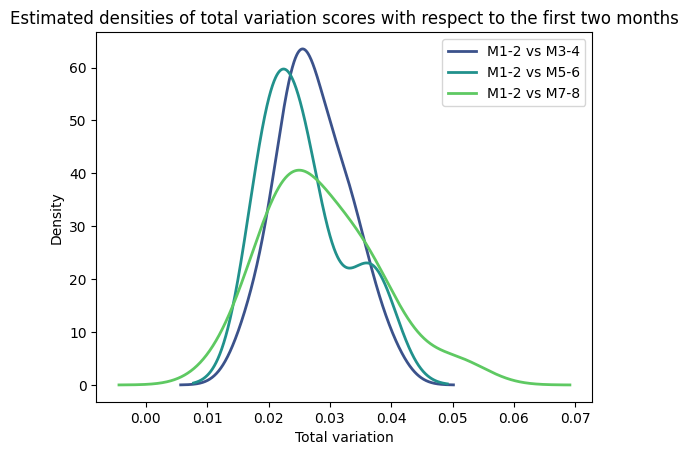

In [34]:
colors = sns.color_palette("viridis", n_colors=len(df.columns))
ax = df.plot.kde(color=colors, linewidth=2)
plt.title('Estimated densities of total variation scores with respect to the first two months')
plt.xlabel('Total variation')
plt.ylabel('Density')
labels = ['M1-2 vs M3-4', 'M1-2 vs M5-6', 'M1-2 vs M7-8']
plt.legend(labels)
plt.show()

# Preference change from previous slot

## Third time slot

In [35]:
common_users_second_third_slot = list(set(second_slot_active_users) & set(third_slot_active_users))
print(len(common_users_second_third_slot))
print(common_users_second_third_slot)

101
[517, 9, 521, 11, 523, 530, 22, 24, 26, 539, 37, 47, 559, 569, 58, 65, 70, 584, 75, 76, 81, 602, 92, 95, 98, 101, 102, 618, 620, 112, 116, 118, 630, 121, 122, 636, 127, 130, 644, 137, 649, 139, 143, 144, 668, 694, 696, 185, 188, 703, 192, 704, 711, 204, 207, 233, 239, 752, 763, 764, 253, 278, 791, 288, 802, 808, 815, 816, 817, 822, 826, 833, 845, 860, 867, 366, 369, 374, 377, 892, 384, 899, 393, 913, 914, 404, 405, 409, 413, 442, 447, 450, 454, 476, 477, 479, 486, 494, 498, 501, 504]


In [36]:
filtered_second_slot_distributions = second_slot_distributions[common_users_second_third_slot]
filtered_second_slot_distributions

tensor([[0.0693, 0.0693, 0.0013,  ..., 0.0693, 0.0693, 0.0693],
        [0.0225, 0.0613, 0.0225,  ..., 0.0613, 0.0613, 0.0613],
        [0.0531, 0.1445, 0.0010,  ..., 0.0195, 0.1445, 0.0010],
        ...,
        [0.0504, 0.0504, 0.1371,  ..., 0.0504, 0.0504, 0.0186],
        [0.0449, 0.1219, 0.0449,  ..., 0.1219, 0.1219, 0.0022],
        [0.1091, 0.1091, 0.0020,  ..., 0.1091, 0.0020, 0.0020]])

In [37]:
filtered_third_slot_distributions = third_slot_distributions[common_users_second_third_slot]
filtered_third_slot_distributions

tensor([[0.0140, 0.0140, 0.0140,  ..., 0.0140, 0.0140, 0.0140],
        [0.0114, 0.0310, 0.0114,  ..., 0.0114, 0.0114, 0.0114],
        [0.0563, 0.0010, 0.0010,  ..., 0.0563, 0.0010, 0.0010],
        ...,
        [0.3134, 0.0021, 0.0021,  ..., 0.0021, 0.0021, 0.0021],
        [0.0374, 0.1017, 0.0019,  ..., 0.1017, 0.2764, 0.0019],
        [0.0506, 0.0186, 0.0025,  ..., 0.0506, 0.0506, 0.0506]])

In [38]:
variation_distance = torch.abs(filtered_second_slot_distributions - filtered_third_slot_distributions) / 2
print(variation_distance.shape)
print(variation_distance)

torch.Size([101, 18])
tensor([[2.7684e-02, 2.7684e-02, 6.3485e-03,  ..., 2.7684e-02, 2.7684e-02,
         2.7684e-02],
        [5.5733e-03, 1.5150e-02, 5.5733e-03,  ..., 2.4934e-02, 2.4934e-02,
         2.4934e-02],
        [1.5881e-03, 7.1712e-02, 2.9086e-05,  ..., 1.8384e-02, 7.1712e-02,
         2.9086e-05],
        ...,
        [1.3146e-01, 2.4168e-02, 6.7509e-02,  ..., 2.4168e-02, 2.4168e-02,
         8.2235e-03],
        [3.7234e-03, 1.0121e-02, 2.1496e-02,  ..., 1.0121e-02, 7.7240e-02,
         1.8538e-04],
        [2.9271e-02, 4.5254e-02, 2.5967e-04,  ..., 2.9271e-02, 2.4287e-02,
         2.4287e-02]])


In [39]:
variation_distance = torch.mean(variation_distance, dim=0)
print(variation_distance.shape)
print(variation_distance)

torch.Size([18])
tensor([0.0312, 0.0269, 0.0220, 0.0237, 0.0353, 0.0341, 0.0155, 0.0465, 0.0177,
        0.0289, 0.0191, 0.0276, 0.0320, 0.0371, 0.0270, 0.0314, 0.0361, 0.0211])


In [40]:
second_third_series = pd.Series(variation_distance)
second_third_series

0     0.031230
1     0.026870
2     0.022021
3     0.023692
4     0.035348
5     0.034104
6     0.015485
7     0.046458
8     0.017702
9     0.028868
10    0.019133
11    0.027580
12    0.031982
13    0.037053
14    0.026991
15    0.031398
16    0.036087
17    0.021060
dtype: float32

## Fourth time slot

In [41]:
common_users_third_fourth_slot = list(set(third_slot_active_users) & set(fourth_slot_active_users))
print(len(common_users_third_fourth_slot))
print(common_users_third_fourth_slot)

104
[11, 12, 13, 523, 524, 530, 20, 22, 24, 26, 542, 37, 556, 47, 569, 58, 65, 75, 76, 587, 595, 88, 90, 602, 97, 98, 101, 102, 618, 620, 116, 118, 630, 633, 121, 635, 122, 127, 130, 648, 137, 649, 139, 650, 662, 153, 673, 163, 685, 694, 696, 703, 192, 193, 711, 206, 207, 739, 229, 233, 748, 239, 752, 764, 784, 815, 816, 817, 313, 829, 318, 833, 845, 340, 860, 862, 867, 369, 374, 892, 387, 393, 405, 409, 921, 931, 422, 428, 442, 447, 448, 450, 455, 463, 476, 477, 486, 494, 496, 498, 499, 500, 501, 504]


In [42]:
filtered_third_slot_distributions = third_slot_distributions[common_users_third_fourth_slot]
filtered_third_slot_distributions

tensor([[0.1283, 0.1283, 0.0009,  ..., 0.1283, 0.0009, 0.0009],
        [0.0530, 0.0530, 0.0530,  ..., 0.0530, 0.0530, 0.0530],
        [0.0534, 0.0534, 0.0534,  ..., 0.0534, 0.0534, 0.0534],
        ...,
        [0.0563, 0.1531, 0.0076,  ..., 0.0563, 0.1531, 0.0028],
        [0.0374, 0.1017, 0.0019,  ..., 0.1017, 0.2764, 0.0019],
        [0.0506, 0.0186, 0.0025,  ..., 0.0506, 0.0506, 0.0506]])

In [43]:
filtered_fourth_slot_distributions = fourth_slot_distributions[common_users_third_fourth_slot]
filtered_fourth_slot_distributions

tensor([[0.0539, 0.1466, 0.1466,  ..., 0.0539, 0.0198, 0.0027],
        [0.0732, 0.0732, 0.0269,  ..., 0.0732, 0.0036, 0.0036],
        [0.0709, 0.0013, 0.0013,  ..., 0.0709, 0.0261, 0.1927],
        ...,
        [0.0364, 0.0989, 0.0364,  ..., 0.0989, 0.0989, 0.0989],
        [0.0416, 0.0021, 0.0021,  ..., 0.0416, 0.0021, 0.3075],
        [0.4050, 0.0027, 0.0027,  ..., 0.0027, 0.0027, 0.0027]])

In [44]:
variation_distance = torch.abs(filtered_third_slot_distributions - filtered_fourth_slot_distributions) / 2
print(variation_distance.shape)
print(variation_distance)

torch.Size([104, 18])
tensor([[3.7163e-02, 9.1775e-03, 7.2878e-02,  ..., 3.7163e-02, 9.4893e-03,
         9.1059e-04],
        [1.0092e-02, 1.0092e-02, 1.3051e-02,  ..., 1.0092e-02, 2.4697e-02,
         2.4697e-02],
        [8.7648e-03, 2.6036e-02, 2.6036e-02,  ..., 8.7648e-03, 1.3644e-02,
         6.9679e-02],
        ...,
        [9.9673e-03, 2.7094e-02, 1.4375e-02,  ..., 2.1279e-02, 2.7094e-02,
         4.8030e-02],
        [2.1036e-03, 4.9806e-02, 1.0473e-04,  ..., 3.0035e-02, 1.3717e-01,
         1.5282e-01],
        [1.7723e-01, 7.9376e-03, 1.0563e-04,  ..., 2.3921e-02, 2.3921e-02,
         2.3921e-02]])


In [45]:
variation_distance = torch.mean(variation_distance, dim=0)
print(variation_distance.shape)
print(variation_distance)

torch.Size([18])
tensor([0.0363, 0.0266, 0.0195, 0.0214, 0.0481, 0.0346, 0.0159, 0.0491, 0.0107,
        0.0274, 0.0184, 0.0245, 0.0302, 0.0464, 0.0289, 0.0344, 0.0315, 0.0165])


In [46]:
third_fourth_series = pd.Series(variation_distance)
third_fourth_series

0     0.036279
1     0.026620
2     0.019519
3     0.021375
4     0.048078
5     0.034637
6     0.015864
7     0.049089
8     0.010724
9     0.027370
10    0.018408
11    0.024515
12    0.030203
13    0.046360
14    0.028882
15    0.034422
16    0.031484
17    0.016523
dtype: float32

## Plot

In [47]:
df = pd.concat([first_second_series, second_third_series, third_fourth_series], axis=1)
df

,0,1,2
0,0.022388,0.031230,0.036279
1,0.023858,0.026870,0.026620
2,0.026554,0.022021,0.019519
3,0.024735,0.023692,0.021375
4,0.034376,0.035348,0.048078
5,0.024961,0.034104,0.034637
6,0.016797,0.015485,0.015864
7,0.029940,0.046458,0.049089
8,0.019274,0.017702,0.010724
9,0.034482,0.028868,0.027370


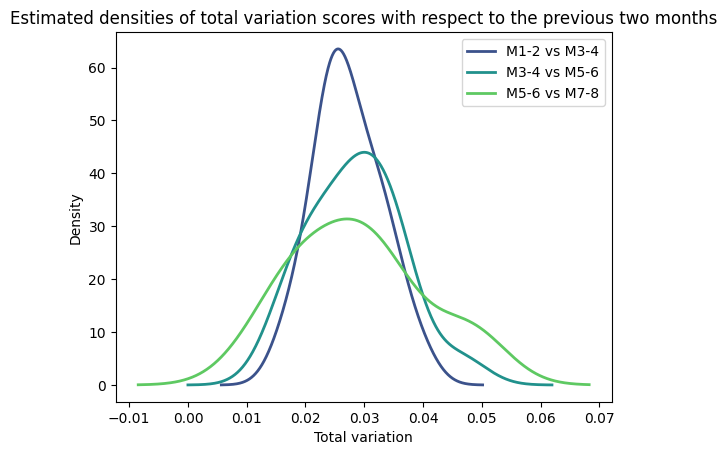

In [48]:
colors = sns.color_palette("viridis", n_colors=len(df.columns))
ax = df.plot.kde(color=colors, linewidth=2)
plt.title('Estimated densities of total variation scores with respect to the previous two months')
plt.xlabel('Total variation')
plt.ylabel('Density')
labels = ['M1-2 vs M3-4', 'M3-4 vs M5-6', 'M5-6 vs M7-8']
plt.legend(labels)
plt.show()

# Preference change from previous slot with full history

## First time slot

In [49]:
start_date_slot_1 = pd.to_datetime('1997-09-20')
end_date_slot_1 = pd.to_datetime('1997-11-01')
dataframe_1 = dataframe[dataframe['Timestamp'].between(start_date_slot_1, end_date_slot_1)]
dataframe_1 = dataframe_1.sort_values(by='Timestamp')
dataframe_1

,UserID,MovieID,CategoryID,Rating,Timestamp,Month
474,101,177,4,4,1997-09-20 03:05:10,1997-09
178269,101,289,7,4,1997-09-20 03:05:27,1997-09
90841,101,153,0,4,1997-09-20 03:05:54,1997-09
45079,101,361,10,4,1997-09-20 03:06:21,1997-09
175466,101,321,0,4,1997-09-20 03:07:23,1997-09
...,...,...,...,...,...,...
45918,92,204,7,4,1997-10-31 23:41:55,1997-10
45419,92,24,2,4,1997-10-31 23:41:55,1997-10
2661,92,68,7,4,1997-10-31 23:42:23,1997-10
39628,92,452,0,4,1997-10-31 23:42:23,1997-10


In [50]:
first_slot_distributions = []
first_slot_active_users = []
for user_id in range(dataset.n_users):
    user_dataframe = dataframe_1[dataframe_1['UserID'] == user_id]
    user_items = user_dataframe['MovieID'].values
    user_distribution, active_user = get_user_distribution(user_dataframe, user_items)
    first_slot_distributions.append(user_distribution)
    if active_user:
        first_slot_active_users.append(user_id)
first_slot_distributions = torch.vstack(first_slot_distributions)
print(first_slot_distributions.shape)
print(first_slot_distributions)
print(len(first_slot_active_users))
print(first_slot_active_users)

torch.Size([943, 18])
tensor([[0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        ...,
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0517, 0.0517, 0.1406,  ..., 0.0517, 0.1406, 0.0009]])
190
[11, 12, 18, 20, 22, 26, 27, 28, 29, 34, 37, 39, 42, 49, 56, 65, 70, 74, 75, 76, 82, 84, 92, 95, 98, 101, 107, 108, 110, 111, 116, 118, 121, 125, 131, 133, 137, 139, 143, 144, 146, 147, 149, 153, 158, 161, 175, 178, 192, 194, 198, 207, 214, 219, 220, 224, 239, 246, 255, 263, 264, 274, 278, 286, 289, 299, 301, 315, 317, 322, 329, 334, 335, 339, 342, 345, 361, 363, 364, 367, 368, 378, 380, 383, 391, 392, 393, 397, 405, 407, 409, 416, 432, 436, 446, 448, 461, 463, 465, 472, 477, 484, 487, 490, 501, 504, 512, 523, 527, 535, 537, 542, 545, 551, 574, 578, 587, 593, 594, 596, 

## Second time slot

In [51]:
start_date_slot_2 = pd.to_datetime('1997-09-20')
end_date_slot_2 = pd.to_datetime('1998-01-01')
dataframe_2 = dataframe[dataframe['Timestamp'].between(start_date_slot_2, end_date_slot_2)]
dataframe_2 = dataframe_2.sort_values(by='Timestamp')
dataframe_2

,UserID,MovieID,CategoryID,Rating,Timestamp,Month
474,101,177,4,4,1997-09-20 03:05:10,1997-09
178269,101,289,7,4,1997-09-20 03:05:27,1997-09
90841,101,153,0,4,1997-09-20 03:05:54,1997-09
45079,101,361,10,4,1997-09-20 03:06:21,1997-09
175466,101,321,0,4,1997-09-20 03:07:23,1997-09
...,...,...,...,...,...,...
152165,288,48,5,4,1997-12-31 23:38:02,1997-12
38809,288,1167,2,3,1997-12-31 23:38:33,1997-12
62684,92,719,0,4,1997-12-31 23:51:08,1997-12
386,92,95,4,4,1997-12-31 23:52:36,1997-12


In [52]:
second_slot_distributions = []
second_slot_active_users = []
for user_id in range(dataset.n_users):
    user_dataframe = dataframe_2[dataframe_2['UserID'] == user_id]
    user_items = user_dataframe['MovieID'].values
    user_distribution, active_user = get_user_distribution(user_dataframe, user_items)
    second_slot_distributions.append(user_distribution)
    if active_user:
        second_slot_active_users.append(user_id)
second_slot_distributions = torch.vstack(second_slot_distributions)
print(second_slot_distributions.shape)
print(second_slot_distributions)
print(len(second_slot_active_users))
print(second_slot_active_users)

torch.Size([943, 18])
tensor([[0.0189, 0.0189, 0.0026,  ..., 0.0026, 0.0514, 0.0026],
        [0.0355, 0.0355, 0.0965,  ..., 0.0965, 0.0355, 0.2622],
        [0.0733, 0.0270, 0.0013,  ..., 0.0733, 0.0733, 0.0733],
        ...,
        [0.0835, 0.0307, 0.0307,  ..., 0.0835, 0.0835, 0.0042],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0517, 0.0517, 0.1406,  ..., 0.0517, 0.1406, 0.0009]])
530
[0, 1, 2, 3, 6, 9, 10, 11, 12, 15, 16, 17, 18, 20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 39, 42, 44, 45, 47, 49, 53, 54, 55, 56, 57, 58, 59, 60, 64, 65, 70, 71, 73, 74, 75, 76, 77, 78, 81, 82, 84, 89, 91, 92, 95, 96, 98, 99, 101, 102, 103, 106, 107, 108, 110, 111, 112, 113, 114, 116, 117, 118, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 133, 135, 137, 138, 139, 141, 143, 144, 146, 147, 149, 150, 151, 152, 153, 156, 158, 159, 161, 166, 173, 174, 175, 178, 181, 182, 183, 185, 186, 187, 188, 192, 194, 197, 198, 199, 200, 202, 204, 207, 212, 213, 214, 2

In [53]:
common_users_first_second_slot = list(set(first_slot_active_users) & set(second_slot_active_users))
print(len(common_users_first_second_slot))
print(common_users_first_second_slot)

190
[512, 523, 11, 12, 527, 18, 20, 22, 535, 537, 26, 27, 28, 29, 542, 545, 34, 37, 39, 551, 42, 49, 56, 574, 65, 578, 70, 74, 75, 76, 587, 593, 82, 594, 84, 596, 602, 92, 95, 98, 101, 618, 107, 108, 621, 110, 111, 627, 116, 118, 630, 121, 635, 125, 639, 131, 133, 645, 137, 139, 652, 143, 144, 146, 147, 658, 149, 662, 153, 668, 158, 161, 676, 679, 681, 683, 685, 175, 689, 178, 690, 691, 701, 703, 192, 705, 194, 706, 198, 711, 713, 207, 721, 214, 727, 728, 219, 220, 224, 738, 749, 239, 246, 759, 255, 767, 770, 771, 772, 773, 263, 264, 776, 781, 274, 278, 792, 793, 795, 286, 800, 289, 809, 810, 299, 301, 813, 826, 315, 317, 830, 322, 834, 838, 329, 845, 334, 335, 339, 852, 342, 345, 860, 862, 864, 867, 869, 361, 363, 364, 878, 367, 368, 882, 883, 889, 378, 380, 383, 895, 391, 392, 393, 905, 397, 909, 912, 915, 405, 407, 409, 416, 928, 935, 937, 942, 432, 436, 446, 448, 461, 463, 465, 472, 477, 484, 487, 490, 501, 504]


In [54]:
filtered_first_slot_distributions = first_slot_distributions[common_users_first_second_slot]
filtered_first_slot_distributions

tensor([[0.0767, 0.0767, 0.0104,  ..., 0.0767, 0.0767, 0.0014],
        [0.0274, 0.0274, 0.0101,  ..., 0.0744, 0.0744, 0.0744],
        [0.0621, 0.0228, 0.0621,  ..., 0.0621, 0.0621, 0.0621],
        ...,
        [0.1036, 0.0019, 0.0019,  ..., 0.1036, 0.0019, 0.0019],
        [0.0584, 0.0584, 0.0584,  ..., 0.0584, 0.0584, 0.0584],
        [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576]])

In [55]:
filtered_second_slot_distributions = second_slot_distributions[common_users_first_second_slot]
filtered_second_slot_distributions

tensor([[0.0767, 0.0767, 0.0104,  ..., 0.0767, 0.0767, 0.0014],
        [0.0257, 0.0257, 0.0257,  ..., 0.0699, 0.0699, 0.0699],
        [0.0621, 0.0228, 0.0621,  ..., 0.0621, 0.0621, 0.0621],
        ...,
        [0.1036, 0.0019, 0.0019,  ..., 0.1036, 0.0019, 0.0019],
        [0.0584, 0.0584, 0.0584,  ..., 0.0584, 0.0584, 0.0584],
        [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576]])

In [56]:
variation_distance = torch.abs(filtered_first_slot_distributions - filtered_second_slot_distributions) / 2
print(variation_distance.shape)
print(variation_distance)

torch.Size([190, 18])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0008, 0.0008, 0.0078,  ..., 0.0022, 0.0022, 0.0022],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [57]:
variation_distance = torch.mean(variation_distance, dim=0)
print(variation_distance.shape)
print(variation_distance)

torch.Size([18])
tensor([0.0032, 0.0030, 0.0028, 0.0025, 0.0048, 0.0037, 0.0012, 0.0036, 0.0026,
        0.0041, 0.0032, 0.0031, 0.0044, 0.0032, 0.0023, 0.0035, 0.0042, 0.0036])


In [58]:
first_second_series = pd.Series(variation_distance)
first_second_series

0     0.003180
1     0.002981
2     0.002758
3     0.002453
4     0.004770
5     0.003666
6     0.001204
7     0.003590
8     0.002641
9     0.004115
10    0.003207
11    0.003086
12    0.004439
13    0.003164
14    0.002307
15    0.003458
16    0.004164
17    0.003561
dtype: float32

## Third time slot

In [59]:
start_date_slot_3 = pd.to_datetime('1997-09-20')
end_date_slot_3 = pd.to_datetime('1998-03-01')
dataframe_3 = dataframe[dataframe['Timestamp'].between(start_date_slot_3, end_date_slot_3)]
dataframe_3 = dataframe_3.sort_values(by='Timestamp')
dataframe_3

,UserID,MovieID,CategoryID,Rating,Timestamp,Month
474,101,177,4,4,1997-09-20 03:05:10,1997-09
178269,101,289,7,4,1997-09-20 03:05:27,1997-09
90841,101,153,0,4,1997-09-20 03:05:54,1997-09
45079,101,361,10,4,1997-09-20 03:06:21,1997-09
175466,101,321,0,4,1997-09-20 03:07:23,1997-09
...,...,...,...,...,...,...
35133,232,181,0,4,1998-02-28 22:45:39,1998-02
1563,232,464,1,3,1998-02-28 22:46:06,1998-02
179112,232,1104,7,3,1998-02-28 22:46:28,1998-02
5506,232,514,4,2,1998-02-28 22:47:17,1998-02


In [60]:
third_slot_distributions = []
third_slot_active_users = []
for user_id in range(dataset.n_users):
    user_dataframe = dataframe_3[dataframe_3['UserID'] == user_id]
    user_items = user_dataframe['MovieID'].values
    user_distribution, active_user = get_user_distribution(user_dataframe, user_items)
    third_slot_distributions.append(user_distribution)
    if active_user:
        third_slot_active_users.append(user_id)
third_slot_distributions = torch.vstack(third_slot_distributions)
print(third_slot_distributions.shape)
print(third_slot_distributions)
print(len(third_slot_active_users))
print(third_slot_active_users)

torch.Size([943, 18])
tensor([[0.0189, 0.0189, 0.0026,  ..., 0.0026, 0.0514, 0.0026],
        [0.0355, 0.0355, 0.0965,  ..., 0.0965, 0.0355, 0.2622],
        [0.0733, 0.0270, 0.0013,  ..., 0.0733, 0.0733, 0.0733],
        ...,
        [0.0835, 0.0307, 0.0307,  ..., 0.0835, 0.0835, 0.0042],
        [0.0747, 0.0747, 0.0037,  ..., 0.0747, 0.0275, 0.0037],
        [0.0517, 0.0517, 0.1406,  ..., 0.0517, 0.1406, 0.0009]])
736
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64, 65, 66, 67, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 141, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 156, 157, 158, 1

In [61]:
common_users_second_third_slot = list(set(second_slot_active_users) & set(third_slot_active_users))
print(len(common_users_second_third_slot))
print(common_users_second_third_slot)

530
[0, 1, 2, 3, 6, 9, 10, 11, 12, 15, 16, 17, 18, 20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 39, 42, 44, 45, 47, 49, 53, 54, 55, 56, 57, 58, 59, 60, 64, 65, 70, 71, 73, 74, 75, 76, 77, 78, 81, 82, 84, 89, 91, 92, 95, 96, 98, 99, 101, 102, 103, 106, 107, 108, 110, 111, 112, 113, 114, 116, 117, 118, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 133, 135, 137, 138, 139, 141, 143, 144, 146, 147, 149, 150, 151, 152, 153, 156, 158, 159, 161, 166, 173, 174, 175, 178, 181, 182, 183, 185, 186, 187, 188, 192, 194, 197, 198, 199, 200, 202, 204, 207, 212, 213, 214, 215, 219, 220, 221, 222, 223, 224, 225, 227, 228, 233, 235, 237, 239, 240, 241, 242, 243, 244, 246, 249, 251, 253, 255, 256, 257, 260, 261, 263, 264, 265, 270, 272, 273, 274, 278, 279, 281, 282, 283, 284, 286, 288, 289, 290, 295, 298, 299, 300, 301, 302, 303, 304, 310, 315, 317, 320, 321, 322, 327, 329, 332, 334, 335, 339, 342, 343, 345, 346, 349, 352, 354, 356, 358, 360, 361, 363, 364, 365, 366, 367, 368, 369, 374, 3

In [62]:
filtered_second_slot_distributions = second_slot_distributions[common_users_second_third_slot]
filtered_second_slot_distributions

tensor([[0.0189, 0.0189, 0.0026,  ..., 0.0026, 0.0514, 0.0026],
        [0.0355, 0.0355, 0.0965,  ..., 0.0965, 0.0355, 0.2622],
        [0.0733, 0.0270, 0.0013,  ..., 0.0733, 0.0733, 0.0733],
        ...,
        [0.0470, 0.0470, 0.0470,  ..., 0.0470, 0.1276, 0.0009],
        [0.0835, 0.0307, 0.0307,  ..., 0.0835, 0.0835, 0.0042],
        [0.0517, 0.0517, 0.1406,  ..., 0.0517, 0.1406, 0.0009]])

In [63]:
filtered_third_slot_distributions = third_slot_distributions[common_users_second_third_slot]
filtered_third_slot_distributions

tensor([[0.0189, 0.0189, 0.0026,  ..., 0.0026, 0.0514, 0.0026],
        [0.0355, 0.0355, 0.0965,  ..., 0.0965, 0.0355, 0.2622],
        [0.0733, 0.0270, 0.0013,  ..., 0.0733, 0.0733, 0.0733],
        ...,
        [0.0470, 0.0470, 0.0470,  ..., 0.0470, 0.1276, 0.0009],
        [0.0835, 0.0307, 0.0307,  ..., 0.0835, 0.0835, 0.0042],
        [0.0517, 0.0517, 0.1406,  ..., 0.0517, 0.1406, 0.0009]])

In [64]:
variation_distance = torch.abs(filtered_second_slot_distributions - filtered_third_slot_distributions) / 2
print(variation_distance.shape)
print(variation_distance)

torch.Size([530, 18])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [65]:
variation_distance = torch.mean(variation_distance, dim=0)
print(variation_distance.shape)
print(variation_distance)

torch.Size([18])
tensor([0.0010, 0.0013, 0.0013, 0.0011, 0.0012, 0.0013, 0.0004, 0.0018, 0.0012,
        0.0016, 0.0013, 0.0015, 0.0015, 0.0019, 0.0014, 0.0011, 0.0018, 0.0016])


In [66]:
second_third_series = pd.Series(variation_distance)
second_third_series

0     0.000996
1     0.001317
2     0.001327
3     0.001147
4     0.001173
5     0.001342
6     0.000434
7     0.001768
8     0.001240
9     0.001608
10    0.001282
11    0.001548
12    0.001465
13    0.001866
14    0.001352
15    0.001105
16    0.001757
17    0.001630
dtype: float32

## Fourth time slot

In [67]:
start_date_slot_4 = pd.to_datetime('1997-09-20')
end_date_slot_4 = pd.to_datetime('1998-05-01')
dataframe_4 = dataframe[dataframe['Timestamp'].between(start_date_slot_4, end_date_slot_4)]
dataframe_4 = dataframe_4.sort_values(by='Timestamp')
dataframe_4

,UserID,MovieID,CategoryID,Rating,Timestamp,Month
474,101,177,4,4,1997-09-20 03:05:10,1997-09
178269,101,289,7,4,1997-09-20 03:05:27,1997-09
90841,101,153,0,4,1997-09-20 03:05:54,1997-09
45079,101,361,10,4,1997-09-20 03:06:21,1997-09
175466,101,321,0,4,1997-09-20 03:07:23,1997-09
...,...,...,...,...,...,...
168106,724,130,7,4,1998-04-22 23:10:38,1998-04
110040,724,280,12,4,1998-04-22 23:10:38,1998-04
136132,724,175,0,4,1998-04-22 23:10:38,1998-04
98754,724,890,0,4,1998-04-22 23:10:38,1998-04


In [68]:
fourth_slot_distributions = []
fourth_slot_active_users = []
for user_id in range(dataset.n_users):
    user_dataframe = dataframe_4[dataframe_4['UserID'] == user_id]
    user_items = user_dataframe['MovieID'].values
    user_distribution, active_user = get_user_distribution(user_dataframe, user_items)
    fourth_slot_distributions.append(user_distribution)
    if active_user:
        fourth_slot_active_users.append(user_id)
fourth_slot_distributions = torch.vstack(fourth_slot_distributions)
print(fourth_slot_distributions.shape)
print(fourth_slot_distributions)
print(len(fourth_slot_active_users))
print(fourth_slot_active_users)

torch.Size([943, 18])
tensor([[0.0189, 0.0189, 0.0026,  ..., 0.0026, 0.0514, 0.0026],
        [0.0843, 0.0310, 0.0843,  ..., 0.0843, 0.0310, 0.2291],
        [0.0733, 0.0270, 0.0013,  ..., 0.0733, 0.0733, 0.0733],
        ...,
        [0.0835, 0.0307, 0.0307,  ..., 0.0835, 0.0835, 0.0042],
        [0.0747, 0.0747, 0.0037,  ..., 0.0747, 0.0275, 0.0037],
        [0.0517, 0.0517, 0.1406,  ..., 0.0517, 0.1406, 0.0009]])
943
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 

In [69]:
common_users_third_fourth_slot = list(set(third_slot_active_users) & set(fourth_slot_active_users))
print(len(common_users_third_fourth_slot))
print(common_users_third_fourth_slot)

736
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64, 65, 66, 67, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 141, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 163, 166, 167, 168, 169, 172, 173, 174, 175, 178, 181, 182, 183, 185, 186, 187, 188, 191, 192, 193, 194, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 210, 211, 212, 213, 214, 215, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 249, 251, 252, 253, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 268, 2

In [70]:
filtered_third_slot_distributions = third_slot_distributions[common_users_third_fourth_slot]
filtered_third_slot_distributions

tensor([[0.0189, 0.0189, 0.0026,  ..., 0.0026, 0.0514, 0.0026],
        [0.0355, 0.0355, 0.0965,  ..., 0.0965, 0.0355, 0.2622],
        [0.0733, 0.0270, 0.0013,  ..., 0.0733, 0.0733, 0.0733],
        ...,
        [0.0835, 0.0307, 0.0307,  ..., 0.0835, 0.0835, 0.0042],
        [0.0747, 0.0747, 0.0037,  ..., 0.0747, 0.0275, 0.0037],
        [0.0517, 0.0517, 0.1406,  ..., 0.0517, 0.1406, 0.0009]])

In [71]:
filtered_fourth_slot_distributions = fourth_slot_distributions[common_users_third_fourth_slot]
filtered_fourth_slot_distributions

tensor([[0.0189, 0.0189, 0.0026,  ..., 0.0026, 0.0514, 0.0026],
        [0.0843, 0.0310, 0.0843,  ..., 0.0843, 0.0310, 0.2291],
        [0.0733, 0.0270, 0.0013,  ..., 0.0733, 0.0733, 0.0733],
        ...,
        [0.0835, 0.0307, 0.0307,  ..., 0.0835, 0.0835, 0.0042],
        [0.0747, 0.0747, 0.0037,  ..., 0.0747, 0.0275, 0.0037],
        [0.0517, 0.0517, 0.1406,  ..., 0.0517, 0.1406, 0.0009]])

In [72]:
variation_distance = torch.abs(filtered_third_slot_distributions - filtered_fourth_slot_distributions) / 2
print(variation_distance.shape)
print(variation_distance)

torch.Size([736, 18])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0244, 0.0022, 0.0061,  ..., 0.0061, 0.0022, 0.0165],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [73]:
variation_distance = torch.mean(variation_distance, dim=0)
print(variation_distance.shape)
print(variation_distance)

torch.Size([18])
tensor([0.0008, 0.0006, 0.0009, 0.0004, 0.0009, 0.0007, 0.0007, 0.0009, 0.0005,
        0.0009, 0.0005, 0.0007, 0.0009, 0.0007, 0.0006, 0.0006, 0.0008, 0.0007])


In [74]:
third_fourth_series = pd.Series(variation_distance)
third_fourth_series

0     0.000759
1     0.000642
2     0.000856
3     0.000386
4     0.000897
5     0.000726
6     0.000708
7     0.000895
8     0.000516
9     0.000853
10    0.000523
11    0.000656
12    0.000910
13    0.000687
14    0.000636
15    0.000634
16    0.000816
17    0.000723
dtype: float32

## Plot

In [75]:
df = pd.concat([first_second_series, second_third_series, third_fourth_series], axis=1)
df

,0,1,2
0,0.003180,0.000996,0.000759
1,0.002981,0.001317,0.000642
2,0.002758,0.001327,0.000856
3,0.002453,0.001147,0.000386
4,0.004770,0.001173,0.000897
5,0.003666,0.001342,0.000726
6,0.001204,0.000434,0.000708
7,0.003590,0.001768,0.000895
8,0.002641,0.001240,0.000516
9,0.004115,0.001608,0.000853


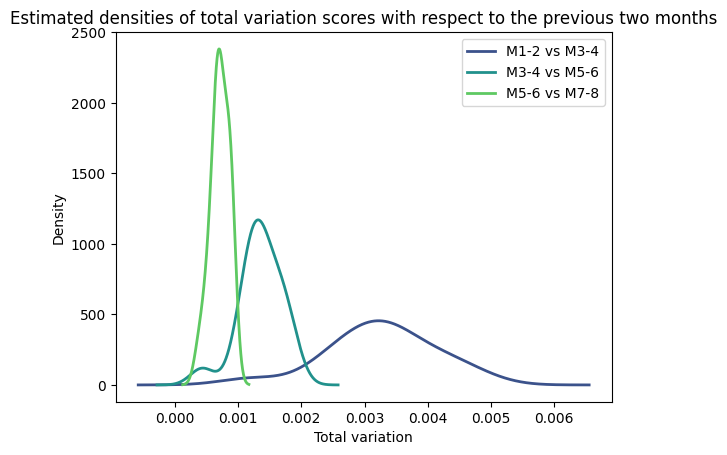

In [76]:
colors = sns.color_palette("viridis", n_colors=len(df.columns))
ax = df.plot.kde(color=colors, linewidth=2)
plt.title('Estimated densities of total variation scores with respect to the previous two months')
plt.xlabel('Total variation')
plt.ylabel('Density')
labels = ['M1-2 vs M3-4', 'M3-4 vs M5-6', 'M5-6 vs M7-8']
plt.legend(labels)
plt.show()